# Text Classification
 - https://realpython.com/python-keras-text-classification/

## 1. Choosing a Data Set

In [1]:
import pandas as pd

filepath_dict = {'yelp':   'dataset/yelp_labelled.txt',
                 'amazon': 'dataset/amazon_cells_labelled.txt',
                 'imdb':   'dataset/imdb_labelled.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [2]:
df

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb


## 2. Defining a Baseline Model

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
#sentences = df['sentence'].values
#y = df['label'].values
df_yelp = df[df['source'] == 'yelp']
sentences = df_yelp['sentence'].values
y = df_yelp['label'].values

In [5]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

## check One-Hot Encoding

In [6]:
cities = ['London', 'Berlin', 'Berlin', 'New York', 'London']
cities

['London', 'Berlin', 'Berlin', 'New York', 'London']

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
encoder = LabelEncoder()
city_labels = encoder.fit_transform(cities)

In [9]:
city_labels

array([1, 0, 0, 2, 1])

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
encoder = OneHotEncoder(sparse=False)

In [12]:
_city_labels = city_labels.reshape((5, 1))

In [13]:
_city_labels

array([[1],
       [0],
       [0],
       [2],
       [1]])

In [14]:
encoder.fit_transform(_city_labels)

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

## 3. Word Embeddings

In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

In [17]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
X_train[1:3],sentences_train[1:3]

([[740, 4, 46, 12, 20, 160, 10, 72, 35, 355, 232],
  [11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]],
 array(['Sorry, I will not be getting food from here anytime soon :(',
        'Of all the dishes, the salmon was the best, but all were great.'],
       dtype=object))

In [18]:
tokenizer.index_word[740]

'sorry'

In [19]:
vocab_size = len(tokenizer.word_index) + 1 
vocab_size

1747

In [20]:
print(sentences_train[2])

Of all the dishes, the salmon was the best, but all were great.


In [21]:
print(X_train[2])

[11, 43, 1, 171, 1, 283, 3, 1, 47, 26, 43, 24, 22]


In [22]:
tokenizer.index_word[11]

'of'

In [23]:
for word in ['the', 'all', 'happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 43
happy: 320
sad: 450


In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [25]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [26]:
print(X_train[2])

[ 11  43   1 171   1 283   3   1  47  26  43  24  22   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [28]:
embedding_dim = 50

In [29]:
model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87350     
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 137,371
Trainable params: 137,371
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)


In [31]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.5067
Testing Accuracy:  0.4800


In [32]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

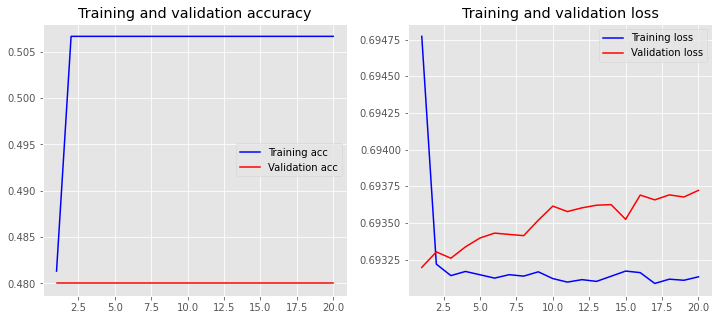

In [33]:
plot_history(history)

## check get embedding layer data

In [34]:
l1, _, _, _ = model.layers

In [35]:
X_train[0]

array([  1,  10,   3, 282, 739,  25,   8, 208,  30,  64, 459, 230,  13,
         1, 124,   5, 231,   8,  58,   5,  67,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [36]:
model.predict(X_train[0:1])

array([[0.4937803]], dtype=float32)

In [37]:
new_model = Sequential()
new_model.add(l1)
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87350     
Total params: 87,350
Trainable params: 87,350
Non-trainable params: 0
_________________________________________________________________


In [38]:
new_model.predict([X_train[0:1]])[0]

array([[ 0.02684011, -0.01867966,  0.03725116, ...,  0.010481  ,
        -0.04307093,  0.03212769],
       [-0.04553328, -0.05614904,  0.04298219, ..., -0.02891034,
         0.04520541, -0.05746911],
       [-0.01105819, -0.05658875, -0.04070503, ..., -0.01932736,
        -0.01334791,  0.0514271 ],
       ...,
       [ 0.02014518,  0.01266654,  0.00750798, ...,  0.01702411,
         0.04076521,  0.0078354 ],
       [ 0.02014518,  0.01266654,  0.00750798, ...,  0.01702411,
         0.04076521,  0.0078354 ],
       [ 0.02014518,  0.01266654,  0.00750798, ...,  0.01702411,
         0.04076521,  0.0078354 ]], dtype=float32)

## 4. Word Embeddings + global max pooling

In [39]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           87350     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 87,871
Trainable params: 87,871
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8040


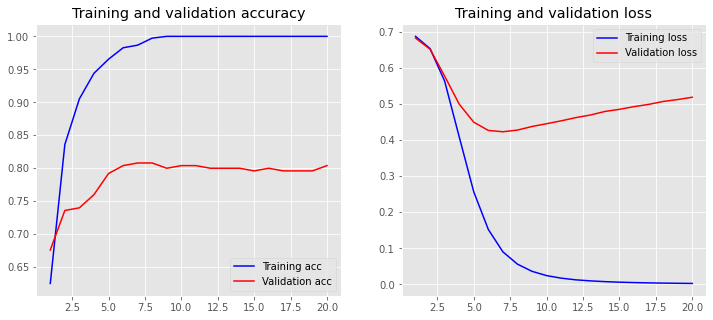

In [40]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)